In [17]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [18]:
def extract_features(image_path):
    img = cv2.imread(image_path, 0)  # Grayscale
    img = cv2.resize(img, (64, 64))
    
    # Threshold and blur for better contours
    img = cv2.GaussianBlur(img, (3, 3), 0)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Hu Moments
    moments = cv2.moments(thresh)
    hu = cv2.HuMoments(moments).flatten()
    hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)  # Log scale for better range

    # HOG Features
    hog_feat = hog(thresh, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)

    return np.hstack([hu, hog_feat])


In [19]:
def load_dataset(folder_path):
    features = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    feat = extract_features(file_path)
                    features.append(feat)
                    labels.append(label)
    return np.array(features), np.array(labels)



In [20]:
dataset_path = "/home/udbhav-purwar/Documents/Project/Airista/Shapes-DS/train"
X, y = load_dataset(dataset_path)



In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [22]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


In [24]:
param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(svm.SVC(), param_grid, refit=True, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


In [25]:
y_pred = grid.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

      circle       1.00      1.00      1.00       573
      square       1.00      1.00      1.00       594
        star       1.00      1.00      1.00       628
    triangle       1.00      1.00      1.00       601

    accuracy                           1.00      2396
   macro avg       1.00      1.00      1.00      2396
weighted avg       1.00      1.00      1.00      2396



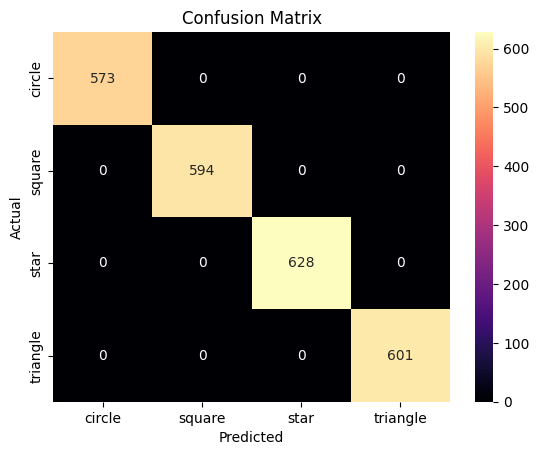

In [26]:
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [27]:
import joblib  # Import joblib for saving models

# Save the trained model
joblib.dump(grid.best_estimator_, 'svm_model.pkl')

# Alternatively, if you want to save the scaler and PCA transformations too:
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')


['pca.pkl']